Import all the functions we need

In [ ]:
import os
import warnings

from model import VideoLearner
from dataset import VideoDataset
from gpu import system_info
system_info()
warnings.filterwarnings('ignore')

This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters. 

Using the paramters below, one can reproduce published results on the HMDB-51 dataset. Video-clip accuracy of close to 80%  can be obtained using as input to the DNN 32 consecutive frames (`MODEL_INPUT_SIZE`) and running 48 training epochs. Even using only 8 epochs the accuracy already reaches 75%. Inference and training speed can be reduced by a factor of 3-4 by setting `MODEL_INPUT_SIZE=8` and using higher batch size, however at a significant loss in accuracy.

In [3]:
# Number of consecutive frames used as input to the DNN. Recommended: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 32

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 4

# Number of training epochs
EPOCHS = 15

# Learning rate
LR = 0.0001

## Downloading HMDB51

Since we're trying to train our model ont he hmdb51 dataset, we'll need to download it. You find the link to download it [here](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/). Once downloaded, set `VIDEO_DIR` to the location of the videos.

In [4]:
DATA_ROOT = os.path.join('ActivityNet', 'Crawler', 'Kinetics')#os.path.join("/mnt/min/Project_cctv/computervision-recipes/scenarios/action_recognition/data", "action")
VIDEO_DIR = os.path.join(DATA_ROOT, "data2")

In [5]:
DATA_ROOT

'ActivityNet/Crawler/Kinetics'

For this notebook, we'll try to reproduce the SOTA results on HMDB51 using a specific train/test split known simply as "split1". Download the split and specify where the download location.

In [6]:
TRAIN_SPLIT = os.path.join(DATA_ROOT, "train1.txt")
TEST_SPLIT = os.path.join(DATA_ROOT, "test1.txt")

In [7]:
data = VideoDataset(
    VIDEO_DIR,
    train_split_file=TRAIN_SPLIT,
    test_split_file=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    sample_length=MODEL_INPUT_SIZE,
    #video_ext="avi"
)

ActivityNet/Crawler/Kinetics/train1.txt


Here's what the train/test split ends up looking like.

In [8]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 4011 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f167d771c90>     
Testing dataset: 1055 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f167d7803d0>


Now that the data is loaded, we can take a quick look at some samples.

<Figure size 432x288 with 0 Axes>

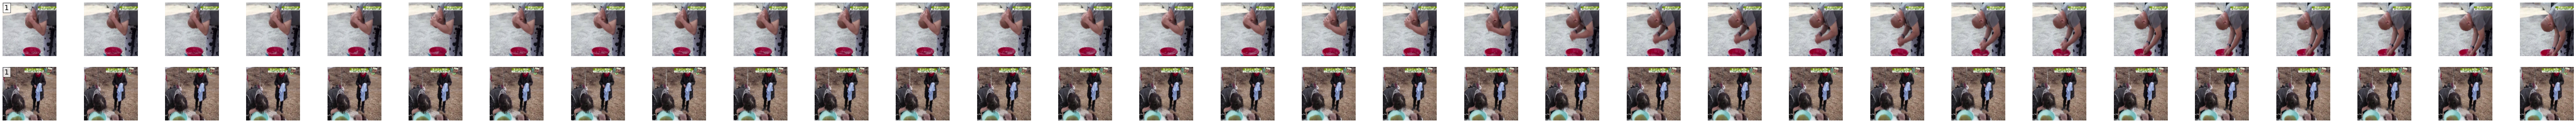

In [9]:
data.show_batch(rows=2)

Lets also take a look at the (default) parameters that we're using:

In [10]:
print(f"""\
sample_length: {data.sample_length}
sample_step: {data.sample_step}
temporal_jitter: {data.temporal_jitter}
temporal_jitter_step: {data.temporal_jitter_step}
random_shift: {data.random_shift}
""")

sample_length: 32
sample_step: 1
temporal_jitter: True
temporal_jitter_step: 2
random_shift: False



## Setup the Video Learner

In [11]:
learner = VideoLearner(data, num_classes=56)

Loading r2plus1d_34_32_ig65m model


Using cache found in /home/shkim/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [12]:
learner.model.fc

Linear(in_features=512, out_features=57, bias=True)

Params to learn:
	full network
Epoch 1 =========================================================
lr=[0.0001]
 Phase train: batch 200 of 1003
 Phase train: batch 400 of 1003
 Phase train: batch 600 of 1003
 Phase train: batch 800 of 1003
 Phase train: batch 1000 of 1003
train took 713.94 sec | loss = 3.5989 | top1_acc = 22.3136  | top5_acc = 35.0536
 Phase valid: batch 200 of 264
valid took 178.54 sec | loss = 3.6660 | top1_acc = 12.2275  | top5_acc = 36.7773
Epoch 2 =========================================================
lr=[0.0001]
 Phase train: batch 200 of 1003
 Phase train: batch 400 of 1003
 Phase train: batch 600 of 1003
 Phase train: batch 800 of 1003
 Phase train: batch 1000 of 1003
train took 715.12 sec | loss = 3.4241 | top1_acc = 21.4660  | top5_acc = 39.4914
 Phase valid: batch 200 of 264
valid took 178.53 sec | loss = 3.5707 | top1_acc = 12.2275  | top5_acc = 31.5640
Epoch 3 =========================================================
lr=[0.0001]
 Phase train: batch 200 of 

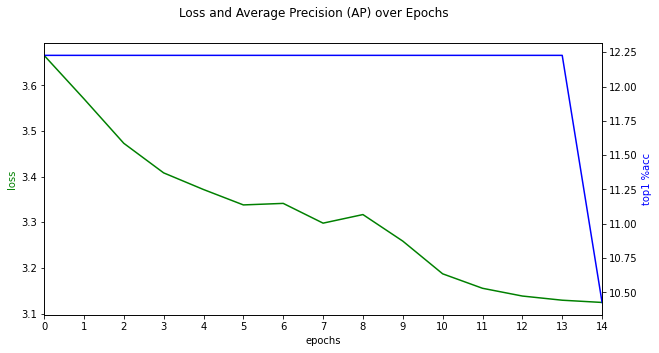

In [13]:
learner.fit(lr=LR, epochs=EPOCHS)

In [21]:
sa = os.path.join("{model_name}_{epoch}.pt".format(model_name=learner.model_name, epoch=EPOCHS))


In [22]:
learner.save(sa)
